# Architecture demonstration

We designed the model architecture as a modification of a classic convolutional architecture - LeNet. We define it as follows:

In [1]:
import torch.nn as nn
from torch import flatten

class CNN_SSH(nn.Module):
    def __init__(self):
        super(CNN_SSH, self).__init__()

        self.cnn_layers_1 = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=4, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(5),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Conv2d(5, 7, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(7),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
        )

        self.cnn_layers_2 = nn.Sequential(
            nn.Conv2d(7, 9, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(9),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
        )
        self.avg_pool = nn.Sequential(nn.AdaptiveAvgPool2d(output_size=(1, 1)))

        self.linear_layers = nn.Sequential(nn.Linear(9, 2), nn.Softmax(dim=1))

    def forward(self, x):
        x = self.cnn_layers_1(x)
        x = self.cnn_layers_2(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


Architecture graph

<img src="./00_demonstrations_data/images/architecture.png" alt="drawing"/>

It is also defined in an external helper file, to avoid discrepancies between files using it. From now on, we will use that definition.

In [2]:
del CNN_SSH
from src.architecture import CNN_SSH

Before we train the model, we need to import the dataset in a PyTorch-compatible format. To do that, we define the `Importer` loader class in [data_loaders.py](./src/data_loaders.py) file.   
It requires passing two arguments: 
* Path to the folder with train/val/test datasets
* default batch size for the respective data loaders. (It can be overriden later, when generating the loaders) 
Its two most important optional arguments are:
* `device` - This allows for efficient memory allocation when using a computation device other than CPU  
* `perturbative_ds` - When you decide to use perturbative approximation for training (datasets with little disorder), this should be the list where you give paths to them.

In [3]:
import pathlib
import pickle
import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd

from src.data_loaders import Importer
from src.training_utils import train_model, plot_training_history
from src.utils import test_model

%reload_ext autoreload
%autoreload 2
%aimport src.training_utils

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Saving

In [4]:
plots_save_path = pathlib.Path("./00_demonstrations_data/figures/")
png_save_path = plots_save_path.joinpath("PNG/")
models_root = pathlib.Path("./00_demonstrations_data/models/")


plots_save_path.mkdir(exist_ok=True, parents=True)
png_save_path.mkdir(exist_ok=True, parents=True)
models_root.mkdir(exist_ok=True, parents=True)

In [5]:
fname = 'training_demonstration'
model_save_folder = models_root.joinpath(fname)
model_save_folder.mkdir(exist_ok=True, parents=True)

Loading

In [6]:
load_path = pathlib.Path("./00_demonstrations_data/datasets")

disorderless_ds_path = load_path.joinpath("disorderless")
disordered_001_ds_path = load_path.joinpath("disordered_W=0.01")
disordered_005_ds_path = load_path.joinpath("disordered_W=0.05")

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else
                        'mps' if torch.backends.mps.is_available() else
                        "cpu")

Let's here reproduce the training which yields better results - with slight disorder added to the training dataset

In [8]:
perturb_list = [disordered_001_ds_path, disordered_005_ds_path]
used_ds_names = [disorderless_ds_path] + perturb_list
used_ds_names = [str(x) for x in used_ds_names]

Training hyperparameters

In [9]:
lr = 1e-4
batch_size = 64
moment = 0.9
weight_decay = 1e-1
epochs = 500

# Early stopping
es_dict = {
    "patience" : 10 if lr < 1e-3 else 20,
    "tolerance" : 0.005 if lr < 1e-3 else 0.01,
    'warmup': 0.1*epochs,
}

Classes definition

In [10]:
num_classes = 2
class_names = ["Trivial", "Topological"]

Data loading

In [14]:
ds = Importer(disorderless_ds_path, batch_size, device, perturbative_ds=perturb_list)
train_loader = ds.get_train_loader(seed=42)
val_loader = ds.get_val_loader()
test_loader = ds.get_test_loader()

Model definition

In [15]:
model = CNN_SSH().float().to(device)

In [16]:
optimizer = optim.SGD(model.parameters(),
                          lr=lr,
                          momentum=moment,
                          weight_decay=weight_decay,
                          )

In [17]:
train_history = train_model(model, 
                            epochs, 
                            train_loader, 
                            val_loader,
                            optimizer, 
                            batch_size, 
                            num_classes, 
                            device,
                            print_all=True, 
                            early_stopping=es_dict,
                            fname=fname,
                            leave=False,
                            )

Epoch:   0%|          | 0/500 [00:00<?, ?epoch/s]

Let's plot the training history

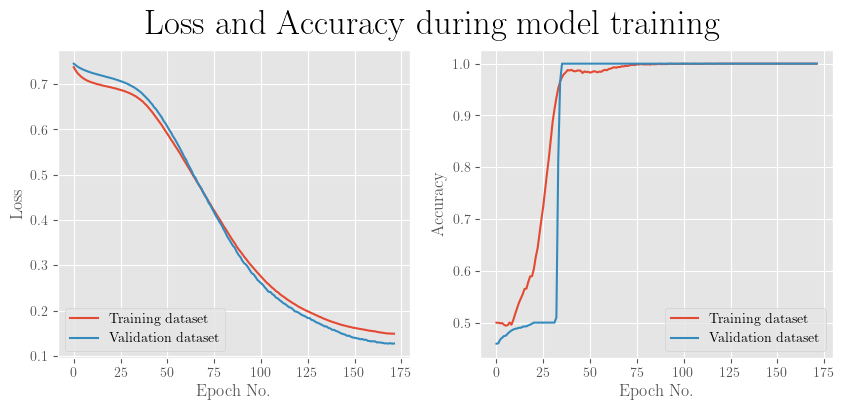

In [18]:
plot_training_history(train_history, plots_save_path, fname)

Now let's test it in-distribution

In [19]:
test_dict = test_model(model, test_loader, class_names, device, verbose=True)
test_df = pd.DataFrame(test_dict)

[INFO] Evaluating network...
              precision    recall  f1-score   support

     Trivial       1.00      1.00      1.00       250
 Topological       1.00      1.00      1.00       250

    accuracy                           1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500



Finally, let's save both the model, and its performance metrics

In [20]:
H = train_history
torch.save(model.state_dict(), model_save_folder.joinpath(f"trained_model.dict"))
with open(model_save_folder.joinpath(f"trained_model_history.pickle"), "wb") as f:
    pickle.dump(train_history, f)
with open(model_save_folder.joinpath(f"trained_model_test.pickle"), "wb") as f:
    pickle.dump(test_dict, f)
# Save the training, validation and test stats to a text file
with open(model_save_folder.joinpath(f"trained_model_stats.txt"), "w") as f:
    f.write(f"Training history:\n")
    f.write(f"Train loss: {H['train_loss'][-1]}\n")
    f.write(f"Validation loss: {H['val_loss'][-1]}\n")
    f.write(f"Train accuracy: {H['train_acc'][-1]}\n")
    f.write(f"Validation accuracy: {H['val_acc'][-1]}\n")
    f.write("Test set\n\n")
    test_df = test_df.applymap(lambda x: round(x, 2))
    test_df.to_string(f)